In [1]:
import scanpy as sc

adata = sc.read_h5ad(
    '../data/tregs.tissue.scps.integrated.annotated.h5ad'
)
adata = adata[adata.obs.status != 'normal', :].copy()
adata

AnnData object with n_obs × n_vars = 4982 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset', 'sat1_status', 'clustering', 'sat1_status_majority_vote'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
import pandas as pd
from pyscenic.prune import df2regulons

def read_pruned_modules(filename):
    df = pd.read_csv(
        filename, 
        sep = '\t', 
        index_col = [0, 1],
        header = [0, 1]
    ) 
    # needs to be reconstituted to actual list and set
    # otherwise aucell won't work
    for column in ['Context', 'TargetGenes']:
        col_data = df.loc[:, ('Enrichment', column)]
        df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
        
    return df


regulons_df = read_pruned_modules(
    '../scenic_results/pruned_modules_recombat_disease_p0.05.tsv',
)
regulons = df2regulons(
    regulons_df
)

/tmp/ipykernel_2697/827190853.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)
/tmp/ipykernel_2697/827190853.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('Enrichment', column)] = col_data.apply(eval)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [14]:
from sklearn.preprocessing import StandardScaler


def multi_index_from_regulons(regulons):
    tuples = []
    for regulon in regulons:
        tuples.extend(
            [(regulon.name, gene) for gene in regulon.genes]
        )
    
    return pd.MultiIndex.from_tuples(tuples)


def sort_cell_by_gene_expression(adata, genes_to_sort_by):
    # assumes that X is already normalized gene expression
    sort_df = adata[:, genes_to_sort_by].to_df()
    return sort_df.sort_values(by = genes_to_sort_by).index.to_list()


def make_regulon_expression_matrix(adata, regulons, sort_cells_by_genes = None, layer = None):
    regulon_index = multi_index_from_regulons(regulons)
    genes = [gene for _, gene in regulon_index]
    regulon_expression_matrix = adata[:, genes].to_df(layer)
    regulon_expression_matrix.columns = regulon_index
    
    if sort_cells_by_genes:
        sort_idx = sort_cell_by_gene_expression(
            adata,
            sort_cells_by_genes
        )
        regulon_expression_matrix = regulon_expression_matrix.reindex(
            labels = sort_idx,
            axis = 'index'
        )
        
    return regulon_expression_matrix


def normalize_total(df, size_factors, target_sum = 1e4):
    return df.divide(size_factors, axis = 0) * target_sum


def scale_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    result_df = pd.DataFrame(
        scaled_data,
        index = df.index,
        columns = df.columns
    )
    return result_df

In [7]:
import numpy as np
import pandas as pd


ngroups = 10

pseudotime = pd.read_csv(
    '../monocle_results/pseudotime.csv',
    index_col = 0
)
pseudotime.columns = ['pseudotime']
pseudotime['groups'] = pd.cut(
    pseudotime.pseudotime,
    bins = np.quantile(
        pseudotime.pseudotime,
        np.linspace(0, 1, ngroups + 1)
    ),
    labels = range(1, ngroups + 1)
)

pseudotime

,pseudotime,groups
AAACCTGAGAGACTAT-57,1.379532,5
AAACCTGAGGCTCAGA-57,7.635210,9
AAACCTGAGTGAAGAG-57,2.660255,6
AAACCTGCACAGAGGT-57,0.010216,3
AAACCTGGTCTACCTC-57,6.277367,8
...,...,...
TCAATCTTCCGTGTGG-167,1.656601,5
TCACTCGAGCTGAGCA-167,0.010111,2
TCATGGAGTCCTTAAG-167,4.106026,7
TCGCAGGAGTGAGTTA-167,2.208792,6


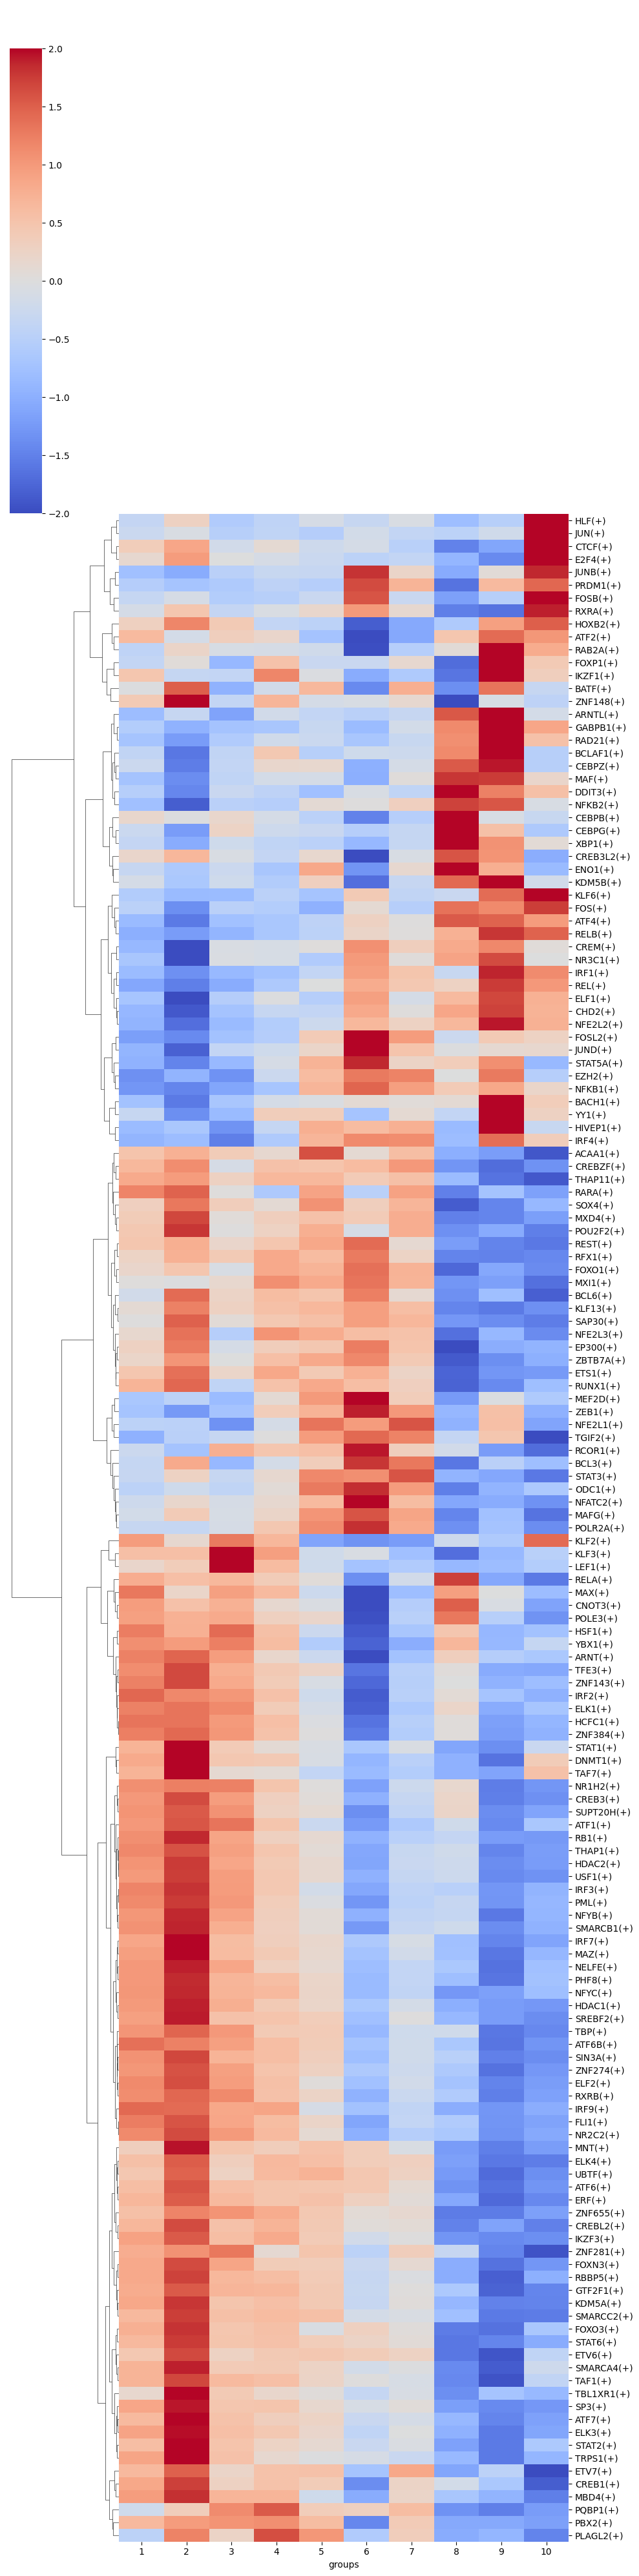

In [16]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

regulon_data = make_regulon_expression_matrix(
    adata,
    regulons,
    layer = 'counts'
)

normalized_regulon_data = normalize_total(
    regulon_data,
    regulon_data.sum(axis = 1)
)

log_normalized_regulon_data = np.log1p(
    normalized_regulon_data
)

# aggregation according to monocle aggregate_gene_expression
# see https://github.com/cole-trapnell-lab/monocle3/blob/master/R/cluster_genes.R
agg_regulon = normalized_regulon_data.T.groupby(level = 0).sum()
agg_regulon = agg_regulon.T.loc[pseudotime.index, :] # reindex just to be sure
agg_regulon_cell = agg_regulon.groupby(pseudotime.groups, observed = True).mean().T
clustergrid = sns.clustermap(
    scale_data(agg_regulon_cell.T).T, # scale rows
    row_cluster = True,
    col_cluster = False,
    vmin = -2, 
    vmax = 2,
    cmap = 'coolwarm',
    figsize = (10, 40),
    method = 'ward',
    cbar_kws = {'fraction': 0.05}
)
clustergrid.savefig('../plots/regulons_aggregated_pseudotime.all.pdf')

# Plot monocle umaps

In [8]:
import pandas as pd
import seaborn as sns

cell_umap_coords = pd.read_csv(
    '../monocle_results/monocle_umap.csv',
    index_col = 0
)
trajectory_umap_coords = pd.read_csv(
    '../monocle_results/monocle_trajectory_umap.csv',
    index_col = 0
).T
trajectory_linkage = pd.read_csv(
    '../monocle_results/monocle_trajectory_linkage.csv',
    index_col = 0
)

In [9]:
cell_umap_coords = pd.concat(
    [
        cell_umap_coords,
        adata.obs.sat1_status_majority_vote,
        pseudotime.pseudotime
    ],
    axis = 1
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def remove_axes(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    for pos in ['top', 'bottom', 'left', 'right']:
        ax.spines[pos].set_visible(False)

    
def plot_trajectory(umap_coords, linkages, ax, c = 'k', highlight_nodes = None):
    for _, link in linkages.iterrows():
        link_idx = [link['from'], link['to']]
        ax.plot(
            umap_coords.loc[link_idx, 1],
            umap_coords.loc[link_idx, 2],
            c = c
        )
        
    if highlight_nodes:
        ax.scatter(
            umap_coords.loc[highlight_nodes, 1],
            umap_coords.loc[highlight_nodes, 2],
            c = 'white',
            edgecolors = 'k',
            s = 100,
            zorder = 5
        )
        

sat1_status_palette = {
    'SAT1_hi': '#ff7f0e',
    'SAT1_lo': '#1f77b4'
}
pseudotime_cmap = LinearSegmentedColormap.from_list(
    'petrols',
    ['#edf8b1', '#7fcdbb', '#2c7fb8'][::-1],
    255
)

        
for color, highlight_nodes, kwargs, plot_cbar, suffix in zip(
    [
        cell_umap_coords['sat1_status_majority_vote'].apply(
            lambda x: sat1_status_palette[x]
        ),
        cell_umap_coords['pseudotime']
    ],
    [False, True],
    [{}, {'vmin': 0, 'vmax': 8, 'cmap': pseudotime_cmap}],
    [False, True],
    ['sat1_status_majority_vote', 'pseudotime']
):
    fig, ax = plt.subplots()
    
    sm = ax.scatter(
        cell_umap_coords.loc[:, 'V1'],
        cell_umap_coords.loc[:, 'V2'],
        c = color,
        edgecolors = 'k',
        linewidths = 0.3,
        **kwargs
    )
    remove_axes(ax)
    
    plot_trajectory(
        trajectory_umap_coords,
        trajectory_linkage,
        ax,
        highlight_nodes = ['Y_1', 'Y_14', 'Y_21'] if highlight_nodes else None
    )
    
    fig.set_figheight(5)
    fig.set_figwidth(5)
    fig.tight_layout()
    fig.savefig(
        f'../plots/monocle_umap_{suffix}.png',
        dpi = 1000
    )
    
    if plot_cbar:
        ax.clear()
        plt.colorbar(
            sm,
            ax = ax
        )
        fig.savefig(
            f'../plots/monocle_umap_{suffix}.colorbar.pdf'
        )